# Kaggle Data Science Challenge - Predicting Survivability on the Titanic

This notebook applies machine learning methods to passanger data from the titanic in an effort to model survivability. By doing so, the model reveals information about passenger attributes which influenced survivability in this disaster.  

## Author
James Bott

In [1]:
# Import built in and external packages
# Should be compatible with kaggle/python Docker image: 
# https://github.com/kaggle/docker-python
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
import re
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# List all files under the input directory
import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# For Kaggle, can write 20GB to the current directory (/kaggle/working/) that gets 
# preserved as output when you create a version using "Save & Run All". You can 
# also write temporary files to /kaggle/temp/, but they won't be saved outside of 
# the current session

kaggle/input\titanic\gender_submission.csv
kaggle/input\titanic\test.csv
kaggle/input\titanic\train.csv


## Loading Raw Data from CSV Files

In this case the development set has already been partitioned into train and test data, however a validation set will be created later on during K-fold cross-validation. The target variable we would like to predict in this case is the "Survived" class, which takes on a boolean value for a classification problem.

In [2]:
# Load from CSV
train_data = pd.read_csv("kaggle/input/titanic/train.csv")
test_data = pd.read_csv("kaggle/input/titanic/test.csv")

# Display first five rows
train_data.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preliminary Analysis of Raw Data

On initially examining the data we find the NaN counts reveal the Age, Embarked and Cabin columns contain incomplete information.  

Additionally, from the Name column we also observe titles which may be useful as a feature. It is possible other features could be deduced from the Name column, for example by integrating with external databases to correct for errors in the Sex column, or reveal information about race or nationality.  

In [3]:
# Extract titles from names by regular expression
titles = train_data['Name'].str.extractall(r"\s(?P<title>[^ ^\.]+)\.")['title']
x = train_data['Ticket'].str.extractall(r"^(?P<x>.*[^ ^0-9]+)\s*[0-9]+$")['x']
cabin = train_data['Cabin'].str.extractall(r"(?P<deck>[^0-9^ ]+)(?P<room>[0-9]+)")
deck = cabin['deck']
room = cabin['room']

print(f"Number of rows: {train_data.shape[0]}")
print(f"Number of rows with empty values: {train_data.isnull().any(axis=1).sum()}")

print(f"Unique values in Pclass column: {sorted(train_data['Pclass'].unique())}")
print(f"Unique values in Sex column: {sorted(train_data['Sex'].unique())}")
print(f"Unique values in SibSp column: {sorted(train_data['SibSp'].unique())}")
print(f"Unique values in Parch column: {sorted(train_data['Parch'].unique())}")
print(f"Unique values in Survived column: {sorted(train_data['Survived'].unique())}")
print(f"Unique values in Embarked column: {sorted(train_data['Embarked'].astype(str).unique())}")

### Preliminary Analysis of Raw Data
print(f"Name titles: {sorted(titles.unique().tolist())}")
print(f"x: {sorted(x.unique().tolist())}")
print(f"deck: {sorted(deck.unique().tolist())}")
print(f"room: {sorted(room.unique().tolist())}")
# ^ Histograms

print("Training data frame information:")
print(train_data.info())

Number of rows: 891
Number of rows with empty values: 708
Unique values in Pclass column: [1, 2, 3]
Unique values in Sex column: ['female', 'male']
Unique values in SibSp column: [0, 1, 2, 3, 4, 5, 8]
Unique values in Parch column: [0, 1, 2, 3, 4, 5, 6]
Unique values in Survived column: [0, 1]
Unique values in Embarked column: ['C', 'Q', 'S', 'nan']
Name titles: ['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'L', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir']
x: ['A./5.', 'A.5.', 'A/4.', 'A/5.', 'A/S', 'A4.', 'C', 'C.A.', 'C.A./SOTON', 'CA', 'CA.', 'F.C.', 'F.C.C.', 'Fa', 'P/PP', 'PC', 'PP', 'S.C./A.4.', 'S.C./PARIS', 'S.O./P.P.', 'S.O.C.', 'S.O.P.', 'S.P.', 'S.W./PP', 'SC', 'SC/AH', 'SC/AH Basle', 'SC/PARIS', 'SC/Paris', 'SCO/W', 'SO/C', 'SOTON/O.Q.', 'SOTON/OQ', 'STON/O 2.', 'STON/O2.', 'SW/PP', 'W./C.', 'W.E.P.', 'W/C', 'WE/P']
deck: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
room: ['10', '101', '102', '103', '104', '106', '11', '110', '111', '118'

## Data Preperation and Feature Engineering

From inspection of the data, initially we observe:

Data preperation applied includes:
* PassengerId will be excluded from the feature set at this stage, as it is expected that PassengerId has been arbitrarily assigned in the database.
* Name, Ticket, Fare and Cabin will be dropped.
* Deck as extracted from the Cabin column will be kept.
* Survived, Pclass, Sex, SibSp, Parch and Embarked are categorical values requiring conversion to one-hot encoding.
* Imputation is applied to feature columns to correct Age, Embarked and Deck columns.
* Age categories are created for EDA.


In [4]:
def preprocessData(df, targetColumn):
    df.drop('PassengerId', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Ticket', axis=1, inplace=True)
    df.drop('Fare', axis=1, inplace=True)
    df["Deck"] = df['Cabin'].str.extract(r"(?P<deck>[^0-9^ ]+)(?P<room>[0-9]+)")["deck"]
    df.drop('Cabin', axis=1, inplace=True)
    
    # Replace non-numeric with NaN
    #df['Fare'] = pd.to_numeric(df['Fare'], errors = 'raise')
    
    # One-hot encoding
    df['Sex'] = df['Sex'].replace(['male','female'], [0, 1])

    parch = pd.get_dummies(df['Parch'], prefix="Parch")
    df.drop('Parch', axis=1, inplace=True)
    df = df.join(parch)

    sibsp = pd.get_dummies(df['SibSp'], prefix="SibSp")
    df.drop('SibSp', axis=1, inplace=True)
    df = df.join(sibsp)

    pclass = pd.get_dummies(df['Pclass'], prefix="Pclass")
    df.drop('Pclass', axis=1, inplace=True)
    df = df.join(pclass)
    
    embarked = pd.get_dummies(df['Embarked'], prefix="Embarked")
    df.drop('Embarked', axis=1, inplace=True)
    df = df.join(embarked)

    deck = pd.get_dummies(df['Deck'], prefix="Deck")
    df.drop('Deck', axis=1, inplace=True)
    df = df.join(deck)
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    featureColumns = [col for col in df.columns if col != targetColumn]
    df[featureColumns] = imputer.fit_transform(df[featureColumns])
    
    df['agel'] = df['Age'] < 3
    df['agem1'] = (df['Age'] >= 3) & (df['Age'] < 11)
    df['agem2'] = (df['Age'] >= 11) & (df['Age'] < 18)
    df['agem3'] = (df['Age'] >= 18) & (df['Age'] < 35)
    df['agem4'] = (df['Age'] >= 35) & (df['Age'] < 55)
    df['ageh'] = df['Age'] >= 55

    #scaler = MinMaxScaler()
    #scaler = StandardScaler()
    #scaler = Normalizer()
    #df[['Fare']] = scaler.fit_transform(df[['Fare']])    
    
    return df

train_data_processed = preprocessData(train_data.copy(), "Survived")
test_data_processed = preprocessData(test_data.copy(), "Survived")

print(train_data_processed.head())

   Survived  Sex   Age  Parch_0  Parch_1  Parch_2  Parch_3  Parch_4  Parch_5  \
0         0  0.0  22.0      1.0      0.0      0.0      0.0      0.0      0.0   
1         1  1.0  38.0      1.0      0.0      0.0      0.0      0.0      0.0   
2         1  1.0  26.0      1.0      0.0      0.0      0.0      0.0      0.0   
3         1  1.0  35.0      1.0      0.0      0.0      0.0      0.0      0.0   
4         0  0.0  35.0      1.0      0.0      0.0      0.0      0.0      0.0   

   Parch_6  ...  Deck_D  Deck_E  Deck_F  Deck_G   agel  agem1  agem2  agem3  \
0      0.0  ...     0.0     0.0     0.0     0.0  False  False  False   True   
1      0.0  ...     0.0     0.0     0.0     0.0  False  False  False  False   
2      0.0  ...     0.0     0.0     0.0     0.0  False  False  False   True   
3      0.0  ...     0.0     0.0     0.0     0.0  False  False  False  False   
4      0.0  ...     0.0     0.0     0.0     0.0  False  False  False  False   

   agem4   ageh  
0  False  False  
1   True

# EDA
In the first step we study the dataset for any patterns which might lead to a bettter understanding of any patterns present in the data.

From the histogram of the age column, we can see that largest represented age range is late 20s. From the bar graph of the target variable we can see that the data is imbalanced. This can be dealt with by over/undersampling in the training set.

## Descriptive Statistics, Histograms and Bar Graphs


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

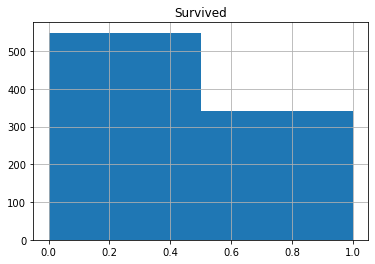

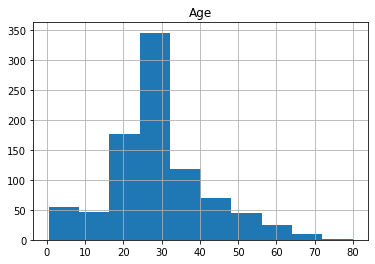

In [5]:

# Bar graph of target variable
train_data_processed.hist(column='Survived', bins=2)

# Histogram of Age Feature
train_data_processed.hist(column='Age')


## Correlation Matrix

Using a rank-order correlation, passanger Sex is the feature most correlated with Survivability. This is followed by having a first-class ticket, being assigned to deck B, and having having one spouse or sibling aboard. The feature most negatively correlated with survivability is being assigned to third class.   

In [6]:
# Display a correlation matrix using a Spearman rank-order correlation 
corr = train_data_processed.corr(method='spearman')

# Select top 5 features with highest correlation to the target label
print("Top 5 features correlated with targed label:")
print(corr['Survived'].sort_values(ascending=False, key=lambda x: abs(x))[1:6])

# Display the correlation matrix
corr.style.background_gradient(cmap='coolwarm')


Top 5 features correlated with targed label:
Sex         0.543351
Pclass_3   -0.322308
Pclass_1    0.285904
Deck_B      0.175095
SibSp_1     0.173076
Name: Survived, dtype: float64


,Survived,Sex,Age,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,agel,agem1,agem2,agem3,agem4,ageh
Survived,1.000000,0.543351,-0.039109,-0.147408,0.134174,0.075020,0.033391,-0.053002,-0.028398,-0.026456,-0.115867,0.173076,0.029796,-0.037215,-0.064123,-0.059292,-0.070234,0.285904,0.093349,-0.322308,0.168240,0.003650,-0.155660,0.022287,0.175095,0.114652,0.146941,0.150716,0.081827,-0.017955,0.082505,0.085221,0.042436,-0.101343,0.038764,-0.033988
Sex,0.543351,1.000000,-0.067809,-0.247523,0.127636,0.170993,0.070383,0.020746,0.070383,0.045439,-0.203203,0.179339,0.042182,0.094850,-0.005735,-0.023967,0.014186,0.098013,0.064746,-0.137143,0.082853,0.074115,-0.125722,-0.078271,0.109689,0.058649,0.070692,0.054368,0.019460,0.040796,0.022378,0.078325,0.069374,-0.064335,0.017020,-0.053224
Age,-0.039109,-0.067809,1.000000,0.217387,-0.113037,-0.232231,0.002317,0.064720,0.081528,0.041743,0.110215,0.039747,-0.089040,-0.102511,-0.223102,-0.113053,0.009379,0.297467,0.021691,-0.273952,0.024368,0.002690,-0.029751,0.100925,0.073944,0.116758,0.109779,0.128123,-0.064213,-0.061140,-0.281564,-0.339815,-0.336203,-0.297462,0.630203,0.368587
Parch_0,-0.147408,-0.247523,0.217387,1.000000,-0.697070,-0.560350,-0.134027,-0.119810,-0.134027,-0.059804,0.420233,-0.223798,-0.080037,-0.201626,-0.256185,-0.134027,-0.158763,-0.008373,-0.039091,0.039029,-0.032550,0.097467,-0.035549,0.052891,-0.091402,-0.020060,-0.012083,-0.029416,-0.074960,-0.069346,-0.296839,-0.374095,-0.072562,0.284829,-0.005506,0.025334
Parch_1,0.134174,0.127636,-0.113037,-0.697070,1.000000,-0.122712,-0.029351,-0.026237,-0.029351,-0.013097,-0.302415,0.229119,0.062474,0.121701,0.155708,-0.029351,-0.034768,0.018496,0.062425,-0.066741,0.065610,-0.049463,-0.024325,-0.051126,0.070737,-0.024150,0.037207,0.081169,0.092982,0.077743,0.241772,0.235096,0.036465,-0.223366,0.027650,0.006838
Parch_2,0.075020,0.170993,-0.232231,-0.560350,-0.122712,1.000000,-0.023594,-0.021091,-0.023594,-0.010528,-0.215801,0.002173,0.033439,0.164475,0.206045,0.239185,0.283327,0.014713,-0.005051,-0.008566,-0.010882,-0.082626,0.062950,-0.010583,0.066389,0.058457,-0.015096,-0.040807,0.007535,0.016520,0.165992,0.292138,0.062005,-0.110680,-0.088909,-0.051332
Parch_3,0.033391,0.070383,0.002317,-0.134027,-0.029351,-0.023594,1.000000,-0.005045,-0.005643,-0.002518,-0.077838,0.064787,0.072586,-0.010158,-0.010787,-0.005643,-0.006685,-0.042496,0.035908,0.007391,0.002199,-0.023105,0.012959,-0.009830,-0.017727,-0.020005,-0.014023,-0.014733,-0.007588,-0.006685,-0.012499,-0.016287,0.047783,-0.032247,0.033444,-0.016709
Parch_4,-0.053002,0.020746,0.064720,-0.119810,-0.026237,-0.021091,-0.005045,1.000000,-0.005045,-0.002251,-0.062369,0.081687,-0.012096,-0.009081,-0.009643,-0.005045,-0.005976,0.001187,-0.034258,0.026859,-0.032371,-0.020654,0.041589,-0.008787,-0.015847,0.049632,-0.012535,-0.013170,-0.006784,-0.005976,-0.011173,-0.014559,-0.016200,-0.049473,0.046198,0.064279
Parch_5,-0.028398,0.070383,0.081528,-0.134027,-0.029351,-0.023594,-0.005643,-0.005045,1.000000,-0.002518,-0.045565,0.064787,-0.013531,-0.010158,-0.010787,-0.005643,-0.006685,-0.042496,-0.038324,0.067804,-0.036212,0.030366,0.012959,-0.009830,-0.017727,-0.020005,-0.014023,-0.014733,-0.007588,-0.006685,-0.012499,-0.016287,-0.018122,-0.093838,0.142862,-0.016709
Parch_6,-0.026456,0.045439,0.041743,-0.059804,-0.013097,-0.010528,-0.002518,-0.002251,-0.002518,1.000000,-0.049132,0.060551,-0.006038,-0.004533,-0.004813,-0.002518,-0.002983,-0.018962,-0.017100,0.030255,-0.016158,-0.010310,0.020759,-0.004386,-0.007910,-0.008926,-0.006257,-0.006574,-0.003386,-0.002983,-0.005577,-0.007267,-0.008086,-0.041871,0.063746,-0.007455


## Principle Component Analysis

Dimensional reduction using PCA could also be explored.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(train_data_processed)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.get_feature_names_out())

# Graph features vs variance

[0.98261357 0.00359841]
[388.07348957  23.48432959]
['pca0' 'pca1']


# Machine Learning Models

Several machine learning models are trained in order to relate the target variable to the feature data.

## Support Vector Machine Model

Training data accuracy was 86.08% and F1 score 81.16% using the support vector classifier.

In [9]:
## 10 fold stratified cross-validation
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Parameter grid
C = [10, 14, 15, 16, 17, 18, 19, 20, 21, 22]
gamma = [0.005, 0.01, 0.015, 0.02, 0.04, 0.05, 0.06, 0.1, 0.11, 0.12]
svc_param_grid = {'C':C,'gamma':gamma}

# Perform a grid-serach using support vector classifer
svc = SVC(kernel='rbf',random_state=0)
svc_grid = GridSearchCV(svc, svc_param_grid, cv=cvKFold)
svc_grid.fit(
    train_data_processed[[col for col in train_data_processed.columns if col != "Survived"]],
    train_data_processed['Survived'])

# Use best parameter set from the grid search to predict data
svc_predictions = svc_grid.predict(train_data_processed[[col for col in train_data_processed.columns if col != "Survived"]])
svc_accuracy = accuracy_score(train_data_processed['Survived'], svc_predictions)
svc_f1 = f1_score(train_data_processed['Survived'], svc_predictions)

print(f"Grid-search best score: {svc_grid.best_score_}")
print(f"Grid-search best parameters: {svc_grid.best_params_}")
print(f"Training set accuracy: {svc_accuracy}")
print(f"Training set F1 score: {svc_f1}")


Grid-search best score: 0.8327465667915106
Grid-search best parameters: {'C': 22, 'gamma': 0.015}
Training set accuracy: 0.8608305274971941
Training set F1 score: 0.8115501519756837


## Random Forest Decision Tree Model

Train data accuracy was 85.52% and F1 score 78.46% using the Random Forest DT model.


In [10]:
# Parameter grid
n_estimators = [55, 60, 65, 70, 75]
max_leaf_nodes = [18, 19, 20, 21]
rfc_param_grid = {'n_estimators':n_estimators,
'max_leaf_nodes':max_leaf_nodes}

# Initiate a RandomForest Classifer
rfc = RandomForestClassifier(max_features='sqrt',criterion="entropy",random_state=0)
# Initiate GridSearch using the rf and parameter grid
rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv=cvKFold)

rfc_grid.fit(
    train_data_processed[[col for col in train_data_processed.columns if col != "Survived"]],
    train_data_processed['Survived'])

# Use best parameter set from the grid search to predict data
rfc_predictions = rfc_grid.predict(train_data_processed[[col for col in train_data_processed.columns if col != "Survived"]])
rfc_accuracy = accuracy_score(train_data_processed['Survived'], rfc_predictions)
rfc_f1 = f1_score(train_data_processed['Survived'], rfc_predictions)

# Print results
print(f"Grid-search best score: {rfc_grid.best_score_}")
print(f"Grid-search best parameters: {rfc_grid.best_params_}")
print(f"Training set accuracy: {rfc_accuracy}")
print(f"Training set F1 score: {rfc_f1}")


Grid-search best score: 0.8260549313358302
Grid-search best parameters: {'max_leaf_nodes': 18, 'n_estimators': 70}
Training set accuracy: 0.8552188552188552
Training set F1 score: 0.7846410684474123
